# ML RUN2 - Incorporating colour

---

In [3]:
# Load in all the required functions

from socket import gethostname

if gethostname() == 'colonsay':
    PATH_START = '/disk1/rohitk/ELN1_project/'

elif gethostname() == 'rohitk-elitebook':
    PATH_START = '/home/rohitk/Documents/PhD/Year1/ELN1_project/'

# Path start for Max_L analysis
PATH_START = PATH_START + "OCT17_ELAIS_im/maxl_test/"
    
#################################################
# Add the path of useful functions at the start

import sys

# Import some important functions
sys.path.append(PATH_START+'../../basic_functions')

# Import coordinate converstion functions
from useful_functions import (coord_matching, nearest_neigh_match, latest_dir, varstat, return_hist_par)
from overlapping_area import (isinpan, isinukidss, isinSWIRE, isinSERVS)
from moc_util import coords_to_hpidx, inMoc
##################################################

import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
import matplotlib.gridspec as gridspec

# Set default properties about all figures
from matplotlib import rcParams

rcParams['figure.figsize'] = 10,10
#from matplotlib import rc
# plt.rc('legend',**{'fontsize':16})
rcParams['axes.labelsize'] = 16
rcParams['axes.linewidth'] = 2
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

import time

from astropy.coordinates import search_around_sky
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky

# Multiprocessin method of doing the ML analysis
import multiprocessing as mp
from functools import partial

from os import makedirs

ts = time.time()
# %pylab inline
import importlib
import os
from time import strftime
from useful_functions import logspace_bins
import glob
import pickle

# For MOC files
import pymoc.io.fits
import healpy as hp
import pymoc.util.catalog

tstart = time.time()

In [4]:
# Import ML functions from mlrun1
import mlrun1_bootes
importlib.reload(mlrun1_bootes)


from mlrun1_bootes import (survey_area, get_bin_list, get_n_m, get_q_m, 
                    generate_rand_pos_servs, get_Q0, compute_Fr, get_nm_interp,
                    get_qm_interp, get_lr,
                   get_giK_bin_indices, get_iK_bin_indices,
                   get_qm_c, gen_binc_binl, get_nm_c, generate_rand_pos_bootes, gen_rand_cat_inMOC)

from mlrun1_bootes import (get_n_m_kde, get_q_m_kde, estimate_q_m_kde, get_sigma_all, fr_u)

# from mlrun1 import survey_area

- [Miscellaneous Functions](#misc-func)
- [Load Catalogues](#load-catalogues)
- [ML Colour Analysis](#ml_colour)
- [giK Colour Categories](#gik_col_cat)
- [gis only Categories](#gis_only_col_cat)
- [K/Ks only Categories](#ks_only_col_cat)
- [Colour Bin Definition](#dict_col_cat)

## Miscellaneous <a class="anchor" id="misc-func"></a>

In [5]:
def completeness(lr, threshold, q0):
    n = len(lr)
    lrt = lr[lr < threshold]
    return 1. - np.sum((q0 * lrt)/(q0 * lrt + (1 - q0)))/float(n)/q0

def reliability(lr, threshold, q0):
    n = len(lr)
    lrt = lr[lr > threshold]
    return 1. - np.sum((1. - q0)/(q0 * lrt + (1 - q0)))/float(n)/q0

completeness_v = np.vectorize(completeness, excluded=[0])
reliability_v = np.vectorize(reliability, excluded=[0])

def comp_rel_threshold(lr, threshold, q0):
    """
    Function to compute the crossing point of the completeness and reliability graph
    """

    completeness_t = completeness_v(lr, threshold, q0)
    reliability_t = reliability_v(lr, threshold, q0)
    average_t = (completeness_t + reliability_t)/2
    
    # Crossing point of completeness and reliability
    th_cross = threshold[np.argmin(np.abs(completeness_t - reliability_t))]
    
    return th_cross, completeness_t, reliability_t

In [6]:
def plot_qn_c(bin_centres, magnitude_distribution, outfig_fname):
    """
    Function to plot the n(m,c) and q(m,c) distributions
    
    Parameters:
    -----------
    bin_centres: Bin centres used to compute the n(m,c) distribution
    magnitude_distribution: Magnitude distribution of n(m) or q(m) for each category
    """
    
    fig = plt.subplots(figsize=(11,20))
    ratio = .8
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.95, wspace=0.6, hspace=0.5)
        
    for k in range(len(magnitude_distribution)):
        ax = plt.subplot(9,4,k+1)

        # ax = plt.subplot(gs[k])
        plt.plot(bin_centres, magnitude_distribution[k])
        # ax.set_aspect(aspect='equal', adjustable='box')
        
        # Sets the aspect ratio of each subplot
        xvals,yvals = plt.gca().axes.get_xlim(), plt.gca().axes.get_ylim()
        xrange = xvals[1]-xvals[0]
        yrange = yvals[1]-yvals[0]
        plt.gca().set_aspect(ratio*(xrange/yrange), adjustable='box')

        plt.title(col_cat_def[k]["cat"])
    plt.savefig(outfig_fname)
    plt.close() # Doesn't plot the output inline
        
    return


In [7]:
# Definition of the paths
PATH_PYBDSF_RAW = "/disk3/rohitk/Bootes/radio/image_full_ampphase_di_m.NS_shift.blanked.scaled.cat.fits"
PATH_MASTER_LIST = "/disk3/rohitk/Bootes/Bootes_optical/MASTER_catalogue/Bootes_MASTER_opt_spitzer_merged_forML.fits"

In [8]:
"""# Find the latest ML RUN1 output and read that in
catdir = latest_dir("run1_matches_bf_020419/*2019*")
print(catdir)

# Select the type of catalogue to load (srl or gaus)
cat_type = "srl"
field = "Bootes"

PATH_RUN1_MATCHES = catdir + '/' + field + '_ML_RUN1_' + cat_type + '_nanth_ionly.fits'
print(PATH_RUN1_MATCHES)""";

In [9]:
workflow_tier = True

if workflow_tier:
    add_str = "_workflow"
else:
    add_str = ""

In [12]:
# Find the latest ML RUN1 output and read that in
catdir = latest_dir("run1_matches"+add_str+"/*2019*")
print(catdir)

# Select the type of catalogue to load (srl or gaus)
cat_type = "_srl"
field = "Bootes"

PATH_RUN1_MATCHES = catdir + '/' + field + '_ML_RUN1' + cat_type + '_nanth.fits'
print(PATH_RUN1_MATCHES)

run1_matches_workflow/05_04_2019_1
run1_matches_workflow/05_04_2019_1/Bootes_ML_RUN1_srl_nanth.fits


In [13]:
# Load the master and the RUN1 matches
master =  Table.read(PATH_MASTER_LIST, format='fits')

In [14]:
# Read in the MOC file
PATH_MOC = "/disk3/rohitk/Bootes/Bootes_optical/moc_files/Bootes_I-band_MOC.fits"

# Generate a MOC class instance first
cata_moc = pymoc.MOC()
pymoc.io.fits.read_moc_fits(cata_moc, PATH_MOC)

moc_area = cata_moc.area_sq_deg
print("Area of MOC: {0} sq. deg.".format(moc_area))

cat_inmoc = inMoc(master["ALPHA_J2000"], master["DELTA_J2000"], cata_moc)
print("Total no. of sources in MOC (ALL FLAG_DEEPs): {0}".format(np.sum(cat_inmoc)))

Area of MOC: 9.643885598599503 sq. deg.
Total no. of sources in MOC (ALL FLAG_DEEPs): 2172469


## Define the optical and IR magnitude columns

In [15]:
# Define the magnitude/flux columns to use for optical and Spitzer data
opt_ap = "2"  # 3'' aperture magnitude
mid_ap = "2"   # 4'' aperture magnitude

opt_fl_col = "I_flux_" + opt_ap
opt_efl_col = "I_fluxerr_" + opt_ap
opt_mag_col = "I_mag_" + opt_ap

mir_fl_col = "ch2_flux_" + mid_ap
mir_efl_col = "ch2_fluxerr_" + mid_ap
mir_mag_col = "ch2_mag_" + opt_ap

snr_th = 3

masks = master["FLAG_DEEP"].mask

print(np.sum(master["FLAG_DEEP"]==1), np.sum(master["FLAG_DEEP"]==0))

# Set the FLAG_DEEP of Spitzer only sources to -99s
master["FLAG_DEEP"].fill_value = -99
master["FLAG_DEEP"] = master["FLAG_DEEP"].filled(-99)

flag_cond = (master["FLAG_DEEP"] == 1) | (master["FLAG_DEEP"] == -99)
# flag_cond = ~np.isnan(master["FLAG_DEEP"])

print(np.sum(flag_cond), len(master))

# Compute SNR of i and K band
snr_i = master[opt_fl_col] / master[opt_efl_col]
i_det = ((snr_i >= snr_th) & flag_cond & cat_inmoc)


snr_ir = master[mir_fl_col] / master[mir_efl_col]
ir_det = ((snr_ir >= snr_th) & flag_cond & cat_inmoc)

print(np.sum(ir_det))

opt_ir_sources = i_det & ir_det & flag_cond & cat_inmoc

1759884 307006
1907323 2214329
1004793


# Compute the colour categories 

### (1) i-K colour categories
    - Defined as source with a SNR > 3 in both i and K bands and then split into the different colour bins

In [16]:
# Over-ride the aperture to use after doing the SNR calculation
opt_ap = "2"  # 2'' aperture magnitude
mid_ap = "3"  # 3'' aperture magnitude

opt_fl_col = "I_flux_" + opt_ap
opt_efl_col = "I_fluxerr_" + opt_ap
opt_mag_col = "I_mag_" + opt_ap

mir_fl_col = "ch2_flux_" + mid_ap
mir_efl_col = "ch2_fluxerr_" + mid_ap
mir_mag_col = "ch2_mag_" + mid_ap

# Compute the i-K colour for these soruces
master["ich2_col_o"] = np.nan
master["ich2_col_o"][opt_ir_sources] = master[opt_mag_col][opt_ir_sources] - master[mir_mag_col][opt_ir_sources]

print("SNR > 3 in i: {0}".format(np.sum(i_det)))
print("SNR > 3 in ch2: {0}".format(np.sum(ir_det)))
print("SNR > 3 in and i and ch2: {0}".format(np.sum(opt_ir_sources)))

# varstat(master[opt_mag_col][opt_ir_sources])
# varstat(master[mir_mag_col][(snr_i < 3) & (snr_i > 1.)])


SNR > 3 in i: 1468722
SNR > 3 in ch2: 1004793
SNR > 3 in and i and ch2: 869284


### (2) i-only and K-only sources

In [17]:
# Define these as sources with snr_i < 3 or snr_K < 3

i_only = (i_det & ~ir_det & flag_cond & cat_inmoc)
ir_only = (ir_det & ~i_det & flag_cond & cat_inmoc)

print("i-only sources: {0}".format(np.sum(i_only)))
print("ch2-only sources: {0}".format(np.sum(ir_only)))

i-only sources: 599438
ch2-only sources: 135509


In [18]:
varstat(snr_i[i_only])

Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
7.715475   5.448159   13.52624   599438     3.000003329907968 2714.340512 0         


/disk1/rohitk/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [19]:
print("No. of i-ch2 sources: {0}".format(np.sum(opt_ir_sources)))
print("No. of i-only sources: {0}".format(np.sum(i_only)))
print("No. of ir-only sources: {0}".format(np.sum(ir_only)))
print("=========================================")

ncol_tot = np.sum(opt_ir_sources) + np.sum(i_only) + np.sum(ir_only)
print("Total no. of sources: {0}, {1:5.3}%".format(ncol_tot, ncol_tot/np.sum(cat_inmoc)*100))

print("No. of sources in MOC: {0}".format(np.sum(cat_inmoc)))
print("No. of sources in MOC and in some colour category: {0}".format(np.sum(cat_inmoc & (opt_ir_sources | i_only | ir_only))))

No. of i-ch2 sources: 869284
No. of i-only sources: 599438
No. of ir-only sources: 135509
Total no. of sources: 1604231,  73.8%
No. of sources in MOC: 2172469
No. of sources in MOC and in some colour category: 1604231


In [20]:
inmoc_nocat = (cat_inmoc & ~(opt_ir_sources | i_only | ir_only) & (master["FLAG_DEEP"] != 0))

nm_nocat = np.sum(inmoc_nocat) / (moc_area * 3600**2)
print("No. of sources in MOC but with NO colour category: {0}".format(np.sum(inmoc_nocat)))
print("Number density of sources in MOC and with NO colour category: {0}".format(nm_nocat))

# master[inmoc_nocat].write("Bootes_inmoc_notin_any_colcat.fits", format='fits', overwrite=True)

No. of sources in MOC but with NO colour category: 261232
Number density of sources in MOC and with NO colour category: 0.0020901108704964298


In [21]:
varstat(snr_i[inmoc_nocat])

Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
1.893165   2.01829    0.770936   261232     -17.389986075050704 2.999549   0         


In [22]:
# Rectangular region for n(m) calculation
p_ra_down = 217.
p_dec_down = 34.
p_ra_up = 220.
p_dec_up = 35.

In [23]:
final = Table.read(PATH_RUN1_MATCHES, format='fits')

lofar_co = SkyCoord(final['RA'], final['DEC'], unit=(u.deg,u.deg),
                    frame='icrs')

i_coords = SkyCoord(master['ALPHA_J2000'][inmoc_nocat], 
                       master['DELTA_J2000'][inmoc_nocat],
                       unit=(u.deg,u.deg),frame='icrs')
print(len(i_coords))

261232


Timetaken: 2.4898412227630615
Radius Blanks Random Blanks Q_0
1 18230 18169 -0.0033573669436952613
2 18193 17818 -0.02104613312380743
3 18096 17314 -0.04516576181125109
4 17790 16620 -0.07039711191335729
5 17265 15896 -0.08612229491696022
6 16454 15080 -0.09111405835543773
7 15568 14297 -0.08889976918234588
8 14619 13461 -0.08602629819478502
9 13707 12657 -0.0829580469305522


Text(0, 0.5, '$Q_0$')

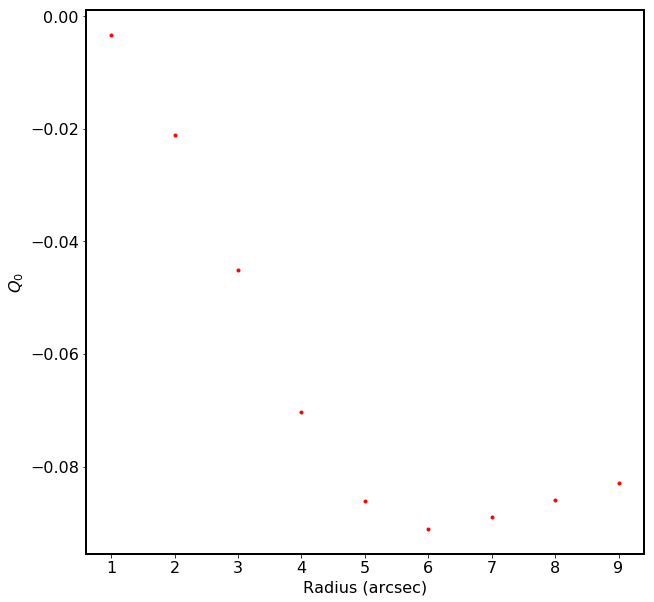

In [24]:
# Get Q0 of the non-colour category
t1 = time.time()

# Empty lists to store the output from the PanSTARRS catalogue
q0_li = []
l_no_m_i = []
r_no_m_i = []

rad = np.arange(1,10)

# Generate random coords
# rand_coords = generate_rand_pos_bootes(p_ra_up,p_dec_up,p_ra_down,p_dec_down,len(lofar_co))
rand_ra_up = 219.8
rand_ra_down = 216.0
rand_dec_up = 35.85
rand_dec_down = 32.25

rand_coords = gen_rand_cat_inMOC(len(lofar_co), rand_ra_up, rand_ra_down, rand_dec_up, rand_dec_down, cata_moc)

for k in range(len(rad)):
    q0_i, nl_non_i, nr_non_i = get_Q0(lofar_co, i_coords, rand_coords, float(rad[k]))
    q0_li.append(q0_i)
    l_no_m_i.append(nl_non_i)
    r_no_m_i.append(nr_non_i)

print('Timetaken: ' + str(time.time() - t1))

print('Radius Blanks Random Blanks Q_0')

for aa in range(len(q0_li)):
    
    print(rad[aa], l_no_m_i[aa], r_no_m_i[aa], q0_li[aa])


# Make a plot of Q0 vs radius
fig_q0 = plt.figure()

plt.plot(rad, q0_li, 'r.')
#plt.yscale('log')
plt.xlabel('Radius (arcsec)')
plt.ylabel('$Q_0$')

# Get the i-K colour bins indices and create the colour groupings

In [25]:
# Separate the objects into the i-K colour indices

"""# Colour bin width
col_bin_width = 0.2

# Number of i-K colour bins
n_ik_bins = len(np.arange(3.5,4.9, col_bin_width)) + 1 + 2 # +2 at the end for the -inf and inf bin

# Generate the un-even width colour bins
iK_col_bins = np.zeros(n_ik_bins)
iK_col_bins[0] = -50. # Some very small small such that the i-K < 3 bin can be calculated
iK_col_bins[1] = 3.
iK_col_bins[2:-1] = np.arange(3.5,4.9,col_bin_width)
iK_col_bins[7] = 4.6
iK_col_bins[8] = 5.
iK_col_bins[9] = 6.
iK_col_bins[-1] = 50.""";


large_binw = 0.5
#iK_col_bins = list(np.arange(-2.0, 0.+large_binw, large_binw))
#iK_col_bins[0] = -40.

small_binw = 0.25
iK_col_bins = []
mid_iK_col_bins = list(np.arange(-0.5+small_binw, 3.5+small_binw, small_binw))
iK_col_bins.extend(mid_iK_col_bins)
iK_col_bins[0] = -40

iK_col_bins.extend(list(np.arange(3.5+large_binw, 5.0, large_binw)))
iK_col_bins[-1] = 40

iK_col_bins = np.array(iK_col_bins)

print("i-K bins: ")
print(iK_col_bins)

i-K bins: 
[-40.     0.     0.25   0.5    0.75   1.     1.25   1.5    1.75   2.
   2.25   2.5    2.75   3.     3.25   3.5    4.    40.  ]


In [26]:
def get_iK_bin_indices(iK_bin_list, iK_colours):
    """
    Get the indices of objects in each giK colour bins 
    10 i-K colour bins --> further divided into 2 equal g-i colour halves
    
    Parameters:
    -----------
    
    iK_bin_list : Bin list of i-K colours
    iK_colours : i-K colour of the sources to be binned
    
    Returns:
    --------
    iK_ind : Indices in each i-K bin, a list of bool arrays
    """
    
    # List of boolean arrays (each of length=len(iK_digitize))
    iK_all_ind = []
    # List of boolean arrays  - BUT each array has length = len(master) - so it an be used for indexing
    iK_full_ind = []

    # Loop counter
    count = 0
    
    # Gives indices of objects in each bin
    for k in range(len(iK_bin_list)-1):
        
        # Bool array of colours within the jth and jth+1 bin
        iK_full_ind.append((iK_colours >= iK_bin_list[k]) & (iK_colours < iK_bin_list[k+1]))
        
    return iK_full_ind # Don't actually need to return iK_all_ind

# Full master indices
master_indices_arr = np.arange(len(master))
# iKcol_master_ind = master_indices_arr[iK_sources]

iK_ind = get_iK_bin_indices(iK_col_bins, master["ich2_col_o"])

/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)
/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [27]:
np.sum(~np.isnan(master["ich2_col_o"]))

869284

### Define the non-colour categories here

In [28]:
print("**** i-4.5 colour bins and master catalogue sources *****")
print("{0} i-4.5 colour categories".format(len(iK_col_bins)-1))
for k in range(len(iK_ind)):
    print("{0} < {1}: {2}".format(iK_col_bins[k], iK_col_bins[k+1], np.sum(iK_ind[k])))

**** i-4.5 colour bins and master catalogue sources *****
17 i-4.5 colour categories
-40.0 < 0.0: 115980
0.0 < 0.25: 47584
0.25 < 0.5: 57457
0.5 < 0.75: 67058
0.75 < 1.0: 75002
1.0 < 1.25: 80777
1.25 < 1.5: 81707
1.5 < 1.75: 77261
1.75 < 2.0: 66036
2.0 < 2.25: 52133
2.25 < 2.5: 39378
2.5 < 2.75: 29694
2.75 < 3.0: 22903
3.0 < 3.25: 17836
3.25 < 3.5: 13738
3.5 < 4.0: 16615
4.0 < 40.0: 8125


In [29]:
# Make a list of the "non-colour" colour categories from the above classifications and the string corresponding to the category
non_col_group = []
non_col_group.append(i_only)
non_col_group.append(ir_only)
non_col_group.append(inmoc_nocat)

### Make a dictionary of colour categories (for the 29 defined categories) <a class="anchor" id="dict_col_cat"></a>

In [30]:
# Make a dictionary of the colour categories

col_cat_def = []
# Build up the dictionary for each of the 29 categories

# Initialise with the 1st category (both lower and upper giK half)
col_cat_def = [{"cat_no":0, "cat":"i45_1",
                "condition":iK_ind[0]}]

############### For the 20 giK colour categories ###############

for k in range(1, len(iK_ind)):
    
    col_cat_def.append({"cat_no":col_cat_def[-1]['cat_no']+1,    # Add 1 to the previous category number
                        "cat":"i45_" + str(k+1),               # Edit the unique category identifier
                        "condition":iK_ind[k]})              # Append the gi <= median bool array

###############  For the non-colour categories #################

# The unique string identifying each of the non-colour categories
non_col_group_str = ["i_only", "ir_only", "no_mag"]  # This is used for making the colour categories dictionary

for k in range(len(non_col_group)):
    
    col_cat_def.append({"cat_no":col_cat_def[-1]['cat_no']+1,
                        "cat":non_col_group_str[k],
                        "condition":non_col_group[k]})

# Print the numbers in each category    
test = []
print("Category # Sources       Cat no.")
for item in col_cat_def:
    print("{0} \t {1}       {2}".format(item['cat'], np.sum(item["condition"]), item["cat_no"]))
    test.append(np.sum(item["condition"]))

print("====================================================")
print("Total no. of sources in ANY category: {0}".format(np.sum(test)))

# Strings of all categories
all_cat = [a['cat'] for a in col_cat_def]
# Total numbers in each colour category
tot_numbers = np.array([np.sum(a["condition"]) for a in col_cat_def])


# For each source in the master catalogue, assign it a category
master["cat_no"] = np.nan
for aa in col_cat_def:
    
    # Assign value=aa wherever the "condition" of the source evaluates to true
    # i.e. if a row in col_cat_def["condition"][aa] == True, assign it the master["cat_no"] = aa
    master["cat_no"][aa["condition"]] = aa["cat_no"]

# Number of master sources not in any category
print("No. of MASTER sources not in any category: " + str(np.sum(np.isnan(master["cat_no"]))))
print("No. of MASTER sources in MOC but with NO colour category: {0}".format(np.sum(cat_inmoc & np.isnan(master["cat_no"]))))
#master.write('MASTER_LIST_0418_with_mag_ccat', format='ascii')

Category # Sources       Cat no.
i45_1 	 115980       0
i45_2 	 47584       1
i45_3 	 57457       2
i45_4 	 67058       3
i45_5 	 75002       4
i45_6 	 80777       5
i45_7 	 81707       6
i45_8 	 77261       7
i45_9 	 66036       8
i45_10 	 52133       9
i45_11 	 39378       10
i45_12 	 29694       11
i45_13 	 22903       12
i45_14 	 17836       13
i45_15 	 13738       14
i45_16 	 16615       15
i45_17 	 8125       16
i_only 	 599438       17
ir_only 	 135509       18
no_mag 	 261232       19
Total no. of sources in ANY category: 1865463
No. of MASTER sources not in any category: 348866
No. of MASTER sources in MOC but with NO colour category: 307006


In [31]:
varstat(master[opt_mag_col][i_only])

Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
24.491571  24.619249  0.689074   599438     15.622948505089159 26.308647  0         


/disk1/rohitk/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [32]:
# List of magnitude column names - fn_opt_indices in apply_ml(*args) function
mag_col_name = []

for a in range(len(col_cat_def)):
    
    if col_cat_def[a]["cat"][:4] == 'i45_' or col_cat_def[a]["cat"] == 'i_only':
        # i.e. if the category is either i-4.5 colour or i_only, then use the i-band colour
        mag_col_name.append(opt_mag_col)
        
    elif col_cat_def[a]["cat"] == 'ir_only':
        mag_col_name.append(mir_mag_col)
        
    elif col_cat_def[a]["cat"] == 'no_mag':
        mag_col_name.append("no_mag")

print("Total no. of colour categories: {0}".format(len(mag_col_name)))
print(mag_col_name)

Total no. of colour categories: 20
['I_mag_2', 'I_mag_2', 'I_mag_2', 'I_mag_2', 'I_mag_2', 'I_mag_2', 'I_mag_2', 'I_mag_2', 'I_mag_2', 'I_mag_2', 'I_mag_2', 'I_mag_2', 'I_mag_2', 'I_mag_2', 'I_mag_2', 'I_mag_2', 'I_mag_2', 'I_mag_2', 'ch2_mag_3', 'no_mag']


In [33]:
# Function to compute ML based on magnitude of possible conterpart and the sigma

def apply_ml(i):
    """
    Function which combines previous routines to compute ML values 
    for each ith LOFAR source that has a match within 15'' to opt/NIR catalogue
    
    Parameters:
    -----------
    i : Index of the LOFAR coordinates
    fn_opt_indices : Field name of indices in MASTER catalogue
    mean_Q0 : Mean Q0 value for the band
    nm_categ : Cumulative n(m) distribution for the category
    qm_categ : Cumulative q(m) distribution for the category
    nm_bc_categ : Bin centres from the n(m) distribution
    
    Returns:
    --------
    res = [opt_index,dist,lr_value] : [Index into the optical catalogue,
                                        Separation to counterpart,
                                        LR value]
    """
    mean_Q0 = Q0_c
    nm_categ = mag_nm_cumul
    qm_categ = mag_qm_cumul
    nm_bc_categ = nm_bin_c
    fn_opt_indices = mag_col_name
    
    # Get the indices into the corresponding MASTER_category catalogue
    indx_o_match = indx_m[indx_l == i]
    s2d_o = s2d[indx_l == i]  # The 2d separation of the sources from LOFAR source
    
    # Indices corresponding to the FULL MASTER catalogue - the -1 to get into python index notation
    indx_o_master = master_categ["ID"][indx_o_match]
    
    # Get the LOFAR positions and errors
    lofar_ra = final['RA'][i]
    lofar_dec = final['DEC'][i]
    lofar_pa = final['PA'][i]
    lofar_maj_err = final['E_Maj'][i]
    lofar_min_err = final['E_Min'][i]
    
    # Get the optical/NIR counterpart positions and positional errors
    c_ra = master_categ['ALPHA_J2000'][indx_o_match]
    c_dec = master_categ['DELTA_J2000'][indx_o_match]
    
    c_ra_err = np.ones(len(indx_o_match)) * 0.35
    c_dec_err = np.ones(len(indx_o_match)) * 0.35
    
    # Get the categories of the possible counterparts
    c_cat_no = master_categ["cat_no"][indx_o_match].astype(int)
    # For each possible counterpart - use the required n(m,c) and q(m,c) based on the cat number
    
    sigma_0_0, det_sigma = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    c_lr = []
    for jj in range(len(c_cat_no)):

        # Define the magnitude colum to use from the list of magnitude columns based on the category of jj'th source
        mag_col_to_use = fn_opt_indices[c_cat_no[jj]]
        
        # Older sigma calculation without the correct angles
        """sig, sig_maj, sig_min = get_sigma_all(lofar_maj_err, lofar_min_err,
                                                  lofar_pa, lofar_ra, lofar_dec,
                                                  c_ra[jj], c_dec[jj], c_ra_err[jj], c_dec_err[jj])"""

        if mag_col_to_use != "no_mag":
            # Magnitude of the jj'th counterpart
            c_mag = master_categ[mag_col_to_use][indx_o_match]

            # mean_Q0[c_cat_no[jj]]
            c_lr.append(get_lr(c_mag[jj], mean_Q0[c_cat_no[jj]], nm_categ[c_cat_no[jj]], qm_categ[c_cat_no[jj]], 
                               np.sqrt(sigma_0_0[jj]), sigma_0_0[jj], det_sigma[jj], (s2d_o.arcsec)[jj],
                               nm_bc_categ, lof_opt_rad, False))
        else:
            
            # This is the case where there is no magnitude or colour information, simply Q0/n * f(r)
            
            # Get f(r) and F(r)
            fr = fr_u((s2d_o.arcsec)[jj], sigma_0_0[jj], det_sigma[jj])
            
            # Compute F(r) using search radius from matching and the combined sigma
            # Fr = compute_Fr(lof_opt_rad, sig)
            # COmpute "q(m)" by factoring Q0 by F(r) to get the expected matches within search radius
            
            qm_fix = null_Q0_nocat   #/ Fr

            c_lr.append(qm_fix * fr / nm_nocat)
    
    # Get indices of n=4 maximum values
    # arr.argsort()[-4:][::-1]

    if np.sum(~np.isnan(c_lr)) == 0:
        result = [np.nan, np.nan, np.nan]

        if not os.path.exists(outdir_name + "/nan_slices/"):
            os.makedirs(outdir_name + "/nan_slices/")
            
        pickle.dump([i, indx_o_master], open(outdir_name+"/nan_slices/list_lofar_and_masterfull_ind_{0}.pckl".format(run_count), "wb"))
        
        with open(outdir_name + "/nan_slices/nan_slice_masterfull_ind_{0}.txt".format(run_count), 'a') as fout:
            fout.write(' '.join([str(aa) for aa in indx_o_master]) + "\n")

        with open(outdir_name + "/nan_slices/nan_slice_lofar_ind_{0}.txt".format(run_count), 'a') as fout:
            fout.write(str(i) + "\n")
    else:
        # Get the index of the maximum
        lr_max_ind = np.nanargmax(c_lr)
        
        result = [indx_o_master[lr_max_ind],            # i_band_index into the master catalogue
              (s2d_o.arcsec)[lr_max_ind],           # Separation between counterpart and LOFAR source
              c_lr[lr_max_ind]]                     # Max LR value
    
    return result

### Delete all the unnecessary data and columns to save memory
Remove all columns other than raErr and decErr (xErr and yErr for K-band)

In [34]:
del iK_ind, non_col_group, i_only, ir_only, i_det, ir_det, opt_ir_sources, snr_i, snr_ir, inmoc_nocat

# Everything above are parameters that don't change

---

In [35]:
# Make a directory based on when the code is run to store output

# Make the general directory to store the catalogue
if os.path.exists(strftime("colour_runs"+add_str+"/%d_%m_%Y_1")):
    # Get list of directories created today
    outdir_name = strftime("colour_runs"+add_str+"/%d_%m_%Y")
    dirs_today = sorted(glob.glob(outdir_name+"*"))

    # Now create a new output directory name by adding one to the last number
    last_num = int(dirs_today[-1][-1])+1

    # Now finally create the directory
    outdir_name = outdir_name+"_"+str(last_num)
    os.makedirs(outdir_name)
    outdir_intermediate = outdir_name+'/interm_output'
    os.makedirs(outdir_intermediate)
else:
    outdir_name = strftime("colour_runs"+add_str+"/%d_%m_%Y_1")
    os.makedirs(outdir_name)
    outdir_intermediate = outdir_name+'/interm_output'
    os.makedirs(outdir_intermediate)


In [36]:
outdir_name, outdir_intermediate

('colour_runs_workflow/05_04_2019_1',
 'colour_runs_workflow/05_04_2019_1/interm_output')

# Now iterate the LR analysis

-----

In [37]:
# Load the LOFAR catalogue with the RUN1 matches
final = Table.read(PATH_RUN1_MATCHES, format='fits')  ### Find LR > th from initial set of matches

opt_lr = "i"
mir_lr = "ch2"

In [38]:
len(final)

18263

In [39]:
# Find the number of sources above the threshold in any of the bands
n_th = (~np.isnan(final["lr_i"]) | ~np.isnan(final["lr_ch2"]))
print("No. of sources above threshold in any band: " + str(len(final[n_th])))

print("Frac. of LOFAR sources above threshold : " + str(len(final[n_th])/float(len(final))))

final["lr_1"] = np.nan
final["lr_1"][n_th] = np.nanmax((final["lr_i"][n_th], final["lr_ch2"][n_th]), axis=0)
final["lr_type_1"] = 0  # Sets numbers to be 0 for the ~700sources where all LRs in all bands are below threshold
final["lr_type_1"][n_th] = np.nanargmax((final["lr_i"][n_th], final["lr_ch2"][n_th]), axis=0) + 1

# Based on the value of type, assign the MASTER index to lr_index_1 column and dist to the lr_dist_1 column
final["lr_index_1"] = np.nan
final["lr_dist_1"] = np.nan

# Do it in a loop
# String of the bands
band_str = [opt_lr, mir_lr]

for k in range(1,np.nanmax(final["lr_type_1"])+1):

    # Assing the MASTER index of the most likely band counterpart
    final["lr_index_1"][final["lr_type_1"] == k] = final["lr_index_"+band_str[k-1]][final["lr_type_1"] == k]
    
    # Assign the distance to the most likely band counterpart
    final["lr_dist_1"][final["lr_type_1"] == k] = final["lr_dist_"+band_str[k-1]][final["lr_type_1"] == k]

print("No. of NaNs: {0}".format(len(final[np.isnan(final["lr_index_1"])])))
### Associate each of the initial counterparts to the master["cat_no"]

# Colour category of the counterpart
final["cat_no"] = np.nan
final["cat_no"][n_th] = master["cat_no"][(final["lr_index_1"][n_th]).astype(int)]

# The number of nan's ideally should be equal to the no of sources above threshold - but since not all MASTER
# sources have a colour category, it will be lower
print("No. of possible counterparts in any category: " + str(np.sum(~np.isnan(final["cat_no"][n_th]))))
print("No. of possible counterparts NOT in any category: " + str(np.sum(np.isnan(final["cat_no"][n_th]))))

### Finally compute q(m,c)

# Indices of LOFAR catalogue sources within each category
cat_ind = np.array([final["cat_no"] == a["cat_no"] for a in col_cat_def])

# Copy the index field to be used and overwritten in loop
final["lr_index_run_n"] = np.copy(final["lr_index_1"])


No. of sources above threshold in any band: 16018
Frac. of LOFAR sources above threshold : 0.8770738651919181
No. of NaNs: 2245
No. of possible counterparts in any category: 16017
No. of possible counterparts NOT in any category: 1


In [40]:
# Set up the initial conditions before running a while loop to iterate the LR analysis

# Indices of objects within rectangle - for n(m,c)
# Find the indices in the master catalogue within the rectangle
print("*MAX* No. of sources used for n(m,c) calculation, i.e. in MOC (less than this in reality): {0}".format(np.sum(cat_inmoc)))

# Define a parallel processing function

# The number of cpu's to use
ncpu = mp.cpu_count()
ncpu_use = np.max([1, ncpu-1])

def run_parallel_c(i):
    
    pool = mp.Pool(processes=ncpu_use)
    resu = pool.map(apply_ml,i)
    return resu

# Initial value for number of categories where difference in source between previous run is non-zero
diff_no_lofar_sum = 800
n_changes = 800

# Max number of sources per category that can change for while loop to converge
tol = 1

# While loop counter
run_count = 1

# The Minimum Q0 value to set - such that 1 LOFAR source over the whole area might be a possible counterpart
null_Q0 = len(final) / (moc_area * 3600**2)
null_Q0 = 1 / len(final)
null_Q0 = 0.001

null_Q0_nocat = null_Q0

*MAX* No. of sources used for n(m,c) calculation, i.e. in MOC (less than this in reality): 2172469


In [41]:
# Firstly generate bin list and centres
nm_bin_list, nm_bin_c = gen_binc_binl(7., 35., 0.05)

# FIX THE THRESHOLD OF LR
fix_th = False

lofar_co = SkyCoord(final['RA'], final['DEC'], unit=(u.deg, u.deg), frame='icrs')
# New search radius to match the LOFAR and combined PanSTARRS WISE caalogue
lof_opt_rad = 15.

In [42]:
# MAKE SURE n_th changes before the while loop goes to the next iteration
# Run the while loop iterate
tin = time.time()

# Store the LR thresholds
th_runs = []
th_cross_l = []
th_runs_old = []

while diff_no_lofar_sum > tol:
    
    final["lr_index_run_n-1"] = np.copy(final["lr_index_run_n"])
    final["cat_no-1"] = np.copy(final["cat_no"])
    
    print("==================================================")
    print("*************** RUN NUMBER: {0} ***************".format(str(run_count)))
    
    # Number of counterparts in each bin
    no_lofar = np.sum(cat_ind, axis=1)
    print("Number of counterparts in each category:")

    for k in range(len(no_lofar)):
        print(all_cat[k], no_lofar[k])
    
    ################# q(m,c) and n(m,c) ##############

    # Compute n(m) for each category using the master catalogue positions

    # Use a for loop to decide what band magnitude to use for n(m) and q(m) based on a category c

    mag_qm = []
    mag_nm = []

    for a in range(len(cat_ind) - 1):

        # Magnitude distribution of the initial matches within category a (cat_ind[a] gives sources within category a)
        mag_qm.append(master[mag_col_name[a]][(final["lr_index_run_n"][cat_ind[a]]).astype(int)])
            
        # Magnitude distribution of all sources within rectangle and category a
        mag_nm.append(master[mag_col_name[a]][((cat_inmoc) & (master["cat_no"] == a))])

    no_nans = []
    no_nans = [np.sum(np.isnan(aa)) for aa in mag_nm]
    print("No. of nan mag in all colour categories: " + str(np.sum(no_nans)))

    # To get the cumulative q(m,c): bin the the q(m) in each colour category - then calculate cumulative sum

    # Cumulative n(m,c)
    # mag_nm_cumul = np.array([get_nm_c(aa, nm_bin_list, moc_area*3600**2) for aa in mag_nm])
    # mag_nm_cumul = np.array([get_n_m_kde(aa, nm_bin_c, area=moc_area*(3600**2), bandwidth=0.5) for aa in mag_nm])
    
    mag_nm_cumul = []
    for aa in mag_nm:
        if len(aa) != 0:
            mag_nm_cumul.append(get_n_m_kde(aa, nm_bin_c, area=moc_area*(3600**2), bandwidth=0.5))    
        else:
            mag_nm_cumul.append(get_nm_c(aa, nm_bin_list, moc_area*3600**2))
    mag_nm_cumul = np.array(mag_nm_cumul)

    # Cumulative q(m,c)
    # mag_qm_cumul = np.array([get_qm_c(aa, nm_bin_list) for aa in mag_qm])
    # mag_qm_cumul = np.array([get_q_m_kde(aa, nm_bin_c, radius=lof_opt_rad, bandwidth=0.5) for aa in mag_qm])
    
    mag_qm_cumul = []
    for aa in mag_qm:
        if len(aa) != 0:
            mag_qm_cumul.append(get_q_m_kde(aa, nm_bin_c, radius=lof_opt_rad, bandwidth=0.5))
        else:
            mag_qm_cumul.append(get_qm_c(aa, nm_bin_list))
    mag_qm_cumul = np.array(mag_qm_cumul)
    
    # Q0 for each colour category
    Q0_c = no_lofar / float(len(final))
    # For very low Q0_c values, set a minimum of 0.001 otherwise it will iterate down to zero
    Q0_c[Q0_c < null_Q0] = null_Q0
    print("Q0: ")
    print(Q0_c)

    # Total Q0 value - summing over all of them 
    # Q0 = np.sum(no_lofar) / float(len(final))
    Q0 = np.sum(Q0_c)

    # Plot n(m,c)
    plot_qn_c(nm_bin_c, mag_nm_cumul, outdir_intermediate+'/nm_c_run_'+str(run_count+1)+'.pdf')
    plot_qn_c(nm_bin_c, np.cumsum(mag_nm_cumul, axis=1), outdir_intermediate+'/nm_csum_c_run_'+str(run_count+1)+'.pdf')

    # Plot q(m,c)
    plot_qn_c(nm_bin_c, mag_qm_cumul, outdir_intermediate+'/qm_c_run_'+str(run_count+1)+'.pdf')
    plot_qn_c(nm_bin_c, np.cumsum(mag_qm_cumul, axis=1), outdir_intermediate+'/qm_csum_c_run_'+str(run_count+1)+'.pdf')

    ###############################################
    #             Run LR analysis                 #
    ###############################################

    # Select the non-nan category sources in master catalogue - this 
    # excludes the spurious K-band detections that are present in the master catalogue
    master_categ = master[~np.isnan(master["cat_no"])]

    # Convert master positions to SkyCoord object
    master_coords = SkyCoord(master_categ['ALPHA_J2000'], master_categ['DELTA_J2000'],
                             unit=(u.deg, u.deg), frame='icrs')

    # Match the coordinates
    indx_l, indx_m, s2d, _ = search_around_sky(lofar_co, master_coords, 
                                                lof_opt_rad*u.arcsec)

    # Number of unique LOFAR sources with a match to the master catalogue
    ind_l_un = np.unique(indx_l)

    # Now run the parallel process

    # Initialise the columns to store the output of LR values
    final["lr_run_n"] = np.nan
    final["lr_index_run_n"] = np.nan
    final["lr_dist_run_n"] = np.nan

    t2 = time.time()

    res = run_parallel_c(ind_l_un)

    (final["lr_index_run_n"][ind_l_un],
    final["lr_dist_run_n"][ind_l_un],
    final["lr_run_n"][ind_l_un]) = list(map(list, zip(*res)))
    
    del res

    print(time.time() - t2)
    
    # Calculate the threshold 
    threshold_all = np.nanpercentile(final["lr_run_n"], 100*(1 - Q0))
    
    if fix_th == True:        
        # Fix the threshold
        threshold_all = 0.5
    
    th_runs_old.append(threshold_all)
    
    # Compute the completeness and reliability and plot them
    thresholds = np.arange(0., 1.5 * threshold_all, 0.005)
    th_cross, completeness_t, reliability_t = comp_rel_threshold(final["lr_run_n"], thresholds, Q0)
    
    th_runs.append(th_cross)
    th_cross_l.append(th_cross)
    
    fig = plt.figure()
    plt.plot(thresholds, completeness_t, "r-")
    plt.plot(thresholds, reliability_t, "g-")
    # plt.plot(thresholds, average_t, "k-")
    plt.axvline(th_cross, color="k", ls="--")
    plt.axvline(threshold_all, color="y", ls=":")
    plt.xlabel(r"$Threshold$")
    plt.ylabel(r"$Completeness/Reliability$")
    # plt.xscale('log')
    plt.tight_layout()
    plt.savefig(outdir_intermediate+"/completeness_reliability_"+str(run_count+1)+".pdf")
    plt.close()
    
    # Plot the LR values
    lr_n, lr_e, _ = return_hist_par(1, final["lr_run_n"][~np.isnan(final["lr_run_n"])])

    fig = plt.figure()
    plt.hist(final["lr_run_n"][~np.isnan(final["lr_run_n"])], bins=lr_e)
    plt.axvline(threshold_all, 0, 1, color='r')
    plt.yscale('log')
    plt.xlabel('$log(LR)$')
    plt.tight_layout()
    plt.savefig(outdir_intermediate+"/LR_run_"+str(run_count+1)+".pdf")
    plt.close()

    varstat(final["lr_run_n"])
    
    ###########################################
    #            Prepare for next run         #
    #            Update the categories        #
    ###########################################
    # prefilt_lr = np.copy(final["lr_run_n"])  # Uncomment to get the last set of plots working
    
    print("====================\n")
    print("Q0: " + str(Q0))
    print("Threshold: "+ str(threshold_all))
    print("Cross-over threshold: {0}".format(th_cross))
    print("Effective Q0 corresponding to cross-over threshold: {0}".format(np.sum(final["lr_run_n"] >= th_cross)/len(lofar_co)))
    print("No of nan LRs: " + str(len(final[np.isnan(final["lr_run_n"])])))

    print("No of sources below threshold: " + 
          str(len(final["lr_run_n"][final["lr_run_n"] <=threshold_all])))
    print("===================\n")

    # Overwrite the threshold used
    threshold_all = np.copy(th_cross)
    
    # Give all sources below the threshold a nan value
    final["lr_index_run_n"][final["lr_run_n"] < threshold_all] = np.nan
    final["lr_dist_run_n"][final["lr_run_n"] < threshold_all] = np.nan
    final["lr_run_n"][final["lr_run_n"] < threshold_all] = np.nan
    
    # print("No of sources below th or without LR: ", np.sum(np.isnan(final["lr_run_n"])))
    
    # Sources above the threshold - UPDATING n_th here
    n_th = ~np.isnan(final["lr_run_n"])
    
    # Colour category of the counterpart
    final["cat_no"] = np.nan
    final["cat_no"][n_th] = master["cat_no"][(final["lr_index_run_n"][n_th]).astype(int)]
    
    # print("No. of LOFAR matches with no colour category: {0}".format(np.sum(np.isnan(final["cat_no"]))))
    
    # Get the indices of the new categories
    # Indices of LOFAR catalogue sources within each category
    cat_ind = np.array([final["cat_no"] == a["cat_no"] for a in col_cat_def])

    # Number of counterparts in each bin
    no_lofar_r2 = np.sum(cat_ind, axis=1)
    
    # Difference in each colour category between the two runs
    diff_nos = no_lofar_r2 - no_lofar
    print("Total changes between runs: " + str(np.sum(np.abs(diff_nos))))
    for k in range(len(no_lofar)):
        print(all_cat[k], diff_nos[k])
    
    # Update the while loop condition - If no changes then the len(argument) = 0 - while loop stops
    diff_no_lofar_sum = len(diff_nos[np.abs(diff_nos) > tol])   # This is the coorection method
    
    # The below line was adapted for Bootes testing
    diff_no_lofar_sum = np.sum(np.abs(diff_nos))
    
    # Assign the LR, index and dist values to the older field name
    # final["lr_index_n"] = np.copy(final["lr_index_run_n"])
    print("No. of sources in cat {0}: {1}".format(all_cat[2], np.sum(final["cat_no"] == 2)))
    
    n_changes = np.sum((final["lr_index_run_n"] != final["lr_index_run_n-1"]) & 
                      (~np.isnan(final["lr_index_run_n"])) & 
                      (~np.isnan(final["lr_index_run_n-1"])))
    t_changes = np.sum((final["lr_index_run_n"] != final["lr_index_run_n-1"]))
    
    c_changes = np.sum((final["cat_no"] != final["cat_no-1"]) & 
                      (~np.isnan(final["cat_no"])) & 
                      (~np.isnan(final["cat_no-1"])))
    
    print("**** N_changes: {0} ****".format(n_changes))
    print("**** T_changes: {0} ****".format(t_changes))
    print("**** C_changes: {0} ****".format(c_changes))
    
    diff_no_lofar_sum = np.copy(n_changes)
    
    # Update the loop counter
    run_count = run_count + 1
    
    print("Iteration Time: {0}".format(time.time() - tin))

print("Total time taken for iterations: ", time.time() - tin)

*************** RUN NUMBER: 1 ***************
Number of counterparts in each category:
i45_1 243
i45_2 330
i45_3 558
i45_4 856
i45_5 1018
i45_6 1120
i45_7 1028
i45_8 958
i45_9 919
i45_10 879
i45_11 793
i45_12 786
i45_13 799
i45_14 791
i45_15 778
i45_16 1255
i45_17 1056
i_only 5
ir_only 1845
no_mag 0
No. of nan mag in all colour categories: 0
Q0: 
[0.01330559 0.01806932 0.03055358 0.04687072 0.05574112 0.06132618
 0.05628867 0.05245578 0.05032032 0.0481301  0.04342112 0.04303784
 0.04374966 0.04331161 0.04259979 0.06871817 0.05782183 0.001
 0.10102393 0.001     ]
26.813602685928345


/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
207.318956 101.532061 280.787986 18263      1.5279853533592809e-99 2829.21152 0         

Q0: 0.8787453320922083
Threshold: 4.290444701278383
Cross-over threshold: 0.32
Effective Q0 corresponding to cross-over threshold: 0.9086130427640585
No of nan LRs: 207
No of sources below threshold: 2190

Total changes between runs: 655
i45_1 -17
i45_2 4
i45_3 -12
i45_4 -5
i45_5 2
i45_6 7
i45_7 18
i45_8 32
i45_9 22
i45_10 40
i45_11 35
i45_12 49
i45_13 42
i45_14 42
i45_15 26
i45_16 32
i45_17 20
i_only -5
ir_only 245
no_mag 0
No. of sources in cat i45_3: 546
**** N_changes: 141 ****
**** T_changes: 2419 ****
**** C_changes: 94 ****
Iteration Time: 98.71133255958557
*************** RUN NUMBER: 2 ***************
Number of counterparts in each category:
i45_1 226
i45_2 334
i45_3 546
i45_4 851
i45_5 1020
i45_6 1127
i45_7 1046
i45_8 990
i45_9 941
i45_10 919
i45_11 828
i45_12 835
i45_13 841
i45_14 833
i45_15 804
i45_16 1287
i45_

/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)
/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)


No. of nan mag in all colour categories: 0


/disk3/rohitk/Bootes/bootes_lr/mlrun1_bootes.py:684: RuntimeWarning: invalid value encountered in true_divide
  return cumul_n_bins / float(cumul_n_bins[-1])


Q0: 
[0.01237475 0.01828834 0.02989651 0.04659694 0.05585063 0.06170947
 0.05727427 0.05420796 0.05152494 0.05032032 0.04533757 0.04572086
 0.04604939 0.04561135 0.04402344 0.07047035 0.05891694 0.001
 0.11443903 0.001     ]
27.158936262130737


/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
210.538598 104.608169 282.691767 18263      1.875066703137331e-97 2829.336335 0         

Q0: 0.9106130427640584
Threshold: 1.1989308172518112
Cross-over threshold: 0.215
Effective Q0 corresponding to cross-over threshold: 0.91146032962821
No of nan LRs: 244
No of sources below threshold: 1611

Total changes between runs: 56
i45_1 4
i45_2 1
i45_3 0
i45_4 -2
i45_5 4
i45_6 0
i45_7 3
i45_8 7
i45_9 7
i45_10 8
i45_11 5
i45_12 0
i45_13 2
i45_14 1
i45_15 2
i45_16 1
i45_17 0
i_only 0
ir_only 5
no_mag 4
No. of sources in cat i45_3: 546
**** N_changes: 1 ****
**** T_changes: 1672 ****
**** C_changes: 1 ****
Iteration Time: 198.68337893486023
Total time taken for iterations:  198.68356823921204


/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)
/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)


In [43]:
print(np.sum(~np.isnan(final["lr_run_n"])) / len(final))
print(np.sum(no_lofar) / float(len(final)))
print("Actual Q0: ", Q0)

0.91146032962821
0.9086130427640585
Actual Q0:  0.9106130427640584


In [44]:
# print("***** Final categories, Q0, n(m,c) and q(m,c) calculation")

# Number of counterparts in each bin
no_lofar = np.sum(cat_ind, axis=1)
print("Number of counterparts in each category:")

for k in range(len(no_lofar)):
    print(all_cat[k], no_lofar[k])

################# q(m,c) and n(m,c) ##############

# Compute n(m) for each category using the master catalogue positions

# Use a for loop to decide what band magnitude to use for n(m) and q(m) based on a category c

mag_qm = []
mag_nm = []

for a in range(len(cat_ind) - 1):

    # Magnitude distribution of the initial matches within category a (cat_ind[a] gives sources within category a)
    mag_qm.append(master[mag_col_name[a]][(final["lr_index_run_n"][cat_ind[a]]).astype(int)])

    # Magnitude distribution of all sources within rectangle and category a
    mag_nm.append(master[mag_col_name[a]][((cat_inmoc) & (master["cat_no"] == a))])

no_nans = []
no_nans = [np.sum(np.isnan(aa)) for aa in mag_nm]
print("No. of nan mag in all colour categories: " + str(np.sum(no_nans)))

# To get the cumulative q(m,c): bin the the q(m) in each colour category - then calculate cumulative sum

# Cumulative n(m,c)
mag_nm_cumul = []
for aa in mag_nm:
    if len(aa) != 0:
        mag_nm_cumul.append(get_n_m_kde(aa, nm_bin_c, area=moc_area*(3600**2), bandwidth=0.5))    
    else:
        mag_nm_cumul.append(get_nm_c(aa, nm_bin_list, moc_area*3600**2))
mag_nm_cumul = np.array(mag_nm_cumul)

# Cumulative q(m,c)
# mag_qm_cumul = np.array([get_qm_c(aa, nm_bin_list) for aa in mag_qm])
# mag_qm_cumul = np.array([get_q_m_kde(aa, nm_bin_c, radius=lof_opt_rad, bandwidth=0.5) for aa in mag_qm])

mag_qm_cumul = []
for aa in mag_qm:
    if len(aa) != 0:
        mag_qm_cumul.append(get_q_m_kde(aa, nm_bin_c, radius=lof_opt_rad, bandwidth=0.5))
    else:
        mag_qm_cumul.append(get_qm_c(aa, nm_bin_list))
mag_qm_cumul = np.array(mag_qm_cumul)


# Q0 for each colour category
Q0_c = no_lofar / float(len(final))
# For very low Q0_c values, set a minimum of 0.001 otherwise it will iterate down to zero
Q0_c[Q0_c < null_Q0] = null_Q0
print("Q0: ")
print(Q0_c)

# Total Q0 value - summing over all of them 
Q0 = np.sum(Q0_c)

# Plot n(m,c)
plot_qn_c(nm_bin_c, mag_nm_cumul, outdir_intermediate+'/nm_c_run_'+str(run_count+1)+'.pdf')
plot_qn_c(nm_bin_c, np.cumsum(mag_nm_cumul, axis=1), outdir_intermediate+'/nm_csum_c_run_'+str(run_count+1)+'.pdf')

# Plot q(m,c)
plot_qn_c(nm_bin_c, mag_qm_cumul, outdir_intermediate+'/qm_c_run_'+str(run_count+1)+'.pdf')
plot_qn_c(nm_bin_c, np.cumsum(mag_qm_cumul, axis=1), outdir_intermediate+'/qm_csum_c_run_'+str(run_count+1)+'.pdf')

Number of counterparts in each category:
i45_1 230
i45_2 335
i45_3 546
i45_4 849
i45_5 1024
i45_6 1127
i45_7 1049
i45_8 997
i45_9 948
i45_10 927
i45_11 833
i45_12 835
i45_13 843
i45_14 834
i45_15 806
i45_16 1288
i45_17 1076
i_only 0
ir_only 2095
no_mag 4
No. of nan mag in all colour categories: 0


/disk3/rohitk/Bootes/bootes_lr/mlrun1_bootes.py:684: RuntimeWarning: invalid value encountered in true_divide
  return cumul_n_bins / float(cumul_n_bins[-1])


Q0: 
[0.01259377 0.0183431  0.02989651 0.04648743 0.05606965 0.06170947
 0.05743854 0.05459125 0.05190823 0.05075836 0.04561135 0.04572086
 0.0461589  0.0456661  0.04413295 0.07052511 0.05891694 0.001
 0.11471281 0.001     ]


In [45]:
Q0

0.9132413075617368

In [46]:
n_n = np.isnan(final["lr_index_run_n"])
print("Sources without LR values: {0} : {1:4.4f} % ".format(np.sum(n_n), np.sum(n_n)/len(final)*100))
print("Effective fraction of matches: {0:4.4f} %".format(np.sum(~np.isnan(final["lr_run_n"]))/len(final)*100))
print("Threshold values: ")
print(th_runs)

Sources without LR values: 1617 : 8.8540 % 
Effective fraction of matches: 91.1460 %
Threshold values: 
[0.32, 0.215]


In [47]:
# Write the matches to file
# run_type = "_faint_"  # If no flux limit then set run_type = "_"
run_type = "_"
final.write(outdir_name+'/ML_RUN'+str(run_count)+run_type + cat_type + '_nanth', format='ascii', overwrite=True)
final.write(outdir_name+'/ML_RUN'+str(run_count)+run_type + cat_type + '_nanth.fits', format='fits', overwrite=True)

In [48]:
# Save the q(m,c) and n(m,c) from the final iteration
# Filenames to store the intermediate output
nmc_f = '{0}/nm{1}c{2}.txt'.format(outdir_name, run_type, cat_type)
qmc_f = '{0}/qm{1}c{2}.txt'.format(outdir_name, run_type, cat_type)
nmbc_f = '{0}/nm_bin_centres{1}.txt'.format(outdir_name, cat_type)
colgroups_f = '{0}/RUN{1}colour_groupings.txt'.format(outdir_name, run_count)
q0c_f = '{0}/Q0_c{1}.txt'.format(outdir_name, cat_type)
th_f = '{0}/iter_threshold{1}.txt'.format(outdir_name, cat_type)
th_f_old = '{0}/iter_threshold_old{1}.txt'.format(outdir_name, cat_type)

# Or store as a pckl file
pickle.dump([mag_nm_cumul, mag_qm_cumul, nm_bin_c, no_lofar_r2, Q0_c, th_runs],
            open('{0}/col_iter_out{1}.pckl'.format(outdir_name, cat_type), "wb"))

np.savetxt(nmc_f, mag_nm_cumul, delimiter=' ')
np.savetxt(qmc_f, mag_qm_cumul, delimiter=' ')
np.savetxt(nmbc_f, nm_bin_c, delimiter=' ')
np.savetxt(colgroups_f, no_lofar_r2, delimiter=' ', fmt='%d')
np.savetxt(q0c_f, Q0_c, delimiter=' ')
with open(th_f, 'w') as thout:
    for abc in th_runs:
        thout.write(str(abc) + "\n")
with open(th_f_old, 'w') as thout:
    for abc in th_runs_old:
        thout.write(str(abc) + "\n")

In [49]:
print("Time taken for the full code to run: ", time.time() - tstart)

Time taken for the full code to run:  813.0923218727112


In [50]:
# Move the HTML notebook to the output directory
os.system("jupyter-nbconvert MaxL_RUN2_iter.ipynb && mv MaxL_RUN2_iter.html {0}".format(outdir_name))

0

In [51]:
outdir_name

'colour_runs_workflow/05_04_2019_1'

In [69]:
del final, outdir_name, cata_moc

# Now run the calibrated $q(m,c)$ on the FULL LOFAR catalogue (in the overlapping area)

## Load and filter LOFAR Catalogue to overlapping region only

In [70]:
# Definition of the paths
# PATH_PYBDSF_RAW = "/disk3/rohitk/Bootes/radio/image_full_ampphase_di_m.NS_shift.blanked.scaled.cat.fits"
PATH_PYBDSF_RAW = "/disk3/rohitk/Bootes/radio/image_full_ampphase_di_m.NS_shift.blanked.scaled.cat.gaul.fits"

# Read in Final Catalogue - LOFAR DATA
deepfull = Table.read(PATH_PYBDSF_RAW)

In [71]:
# Get the type of catalogue (srl) or (gaul)
if PATH_PYBDSF_RAW.split("/")[-1][-8:-5] == "cat":
    cat_type = "_srl"
    id_type = "Source_id"  # Column name to choose - NOT USED
elif PATH_PYBDSF_RAW.split("/")[-1][-9:-5] == "gaul":
    cat_type = "_gaul"
    id_type = "Gaus_id"

print(cat_type)

_gaul


In [72]:
# Make the general directory to store the catalogue
if os.path.exists(strftime("full_runs"+cat_type+add_str+"/%d_%m_%Y_1")):
    # Get list of directories created today
    outdir_name = strftime("full_runs"+cat_type+add_str+"/%d_%m_%Y")
    dirs_today = sorted(glob.glob(outdir_name+"*"))

    # Now create a new output directory name by adding one to the last number
    last_num = int(dirs_today[-1][-1]) + 1

    # Now finally create the directory
    outdir_name = outdir_name+"_"+str(last_num)
    os.makedirs(outdir_name)
else:
    outdir_name = strftime("full_runs"+cat_type+add_str+"/%d_%m_%Y_1")
    os.makedirs(outdir_name)

In [73]:
outdir_name

'full_runs_gaul_workflow/05_04_2019_1'

In [74]:
# Read in the MOC file
PATH_MOC = "/disk3/rohitk/Bootes/Bootes_optical/moc_files/Bootes_I-band_MOC.fits"

# Generate a MOC class instance first
cata_moc = pymoc.MOC()
pymoc.io.fits.read_moc_fits(cata_moc, PATH_MOC)

moc_area = cata_moc.area_sq_deg
print("Area of MOC: {0} sq. deg.".format(moc_area))

forlr_indx = inMoc(deepfull["RA"], deepfull["DEC"], cata_moc)

final = deepfull[forlr_indx]
print("Total no. of LOFAR sources in MOC: {0}".format(np.sum(forlr_indx)))

Area of MOC: 9.643885598599503 sq. deg.
Total no. of LOFAR sources in MOC: 27040


### Load in the $n(m,c)$, $q(m,c)$ and bins used for $n(m,c)$

In [75]:
# Load the latest colour-calibration directory run on srl catalogue
mldir = latest_dir("colour_runs"+add_str+"/*2019*")
print(mldir)

mag_nm_cumul, mag_qm_cumul, nm_bin_c, _, Q0_c, th_runs  = pickle.load(open('{0}/col_iter_out_srl.pckl'.format(mldir, cat_type), "rb"))
# threshold_fin = float(th_runs[-1])
Q0 = np.sum(Q0_c)

print("Q0:")
print(Q0_c)
print("Final Q0 from calibration: {0}".format(Q0))

colour_runs_workflow/05_04_2019_1
Q0:
[0.01259377 0.0183431  0.02989651 0.04648743 0.05606965 0.06170947
 0.05743854 0.05459125 0.05190823 0.05075836 0.04561135 0.04572086
 0.0461589  0.0456661  0.04413295 0.07052511 0.05891694 0.001
 0.11471281 0.001     ]
Final Q0 from calibration: 0.9132413075617368


### Compute f(r)

In [76]:
lofar_coords = SkyCoord(final["RA"], final["DEC"], unit='deg', frame='icrs')
# Select the non-nan category sources in master catalogue - this 
# excludes the spurious K-band detections that are present in the master catalogue
master_categ = master[~np.isnan(master["cat_no"])]
master_coords = SkyCoord(master_categ["ALPHA_J2000"], master_categ["DELTA_J2000"], unit='deg', frame='icrs')

lof_opt_rad = 15.

# Match the coordinates
indx_l, indx_m, s2d, _ = search_around_sky(lofar_coords, master_coords, 
                                           lof_opt_rad*u.arcsec)
# Only take the unique values
ind_l_un = np.unique(indx_l)
print(len(ind_l_un))

26677


In [77]:
null_Q0 = 0.001
null_Q0_nocat = null_Q0
run_count = 0

In [78]:
ncpu = mp.cpu_count()
ncpu_use = np.max([1, ncpu-1])

def run_parallel_c(i):
    
    pool = mp.Pool(processes=ncpu_use)
    resu = pool.map(apply_ml,i)
    return resu

tfin = time.time()

res = run_parallel_c(ind_l_un)

print(time.time() - tfin)

# Create columns in the LOFAR catalogue to store the output of ML in iband
final["lr_fin"] = np.nan
final["lr_dist_fin"] = np.nan
final["lr_index_fin"] = np.nan

# Map the outputs to a list - all non-matches have a nan value
(final["lr_index_fin"][ind_l_un],
 final["lr_dist_fin"][ind_l_un],
 final["lr_fin"][ind_l_un]) = list(map(list, zip(*res)))

varstat(final["lr_fin"])

41.89621615409851
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
157.270283 58.045857  251.910679 27040      4.1688981425717366e-100 2557.264466 0         


Q0: 0.9132413075617368
Final Threshold:  0.215
No of nan LRs: 433
No of sources below 0.1: 3983
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.006641   0.0        0.018216   3983       4.1688981425717366e-100 0.099807   0         
No of sources below threshold: 4223


Text(0.5, 0, 'log(LR)')

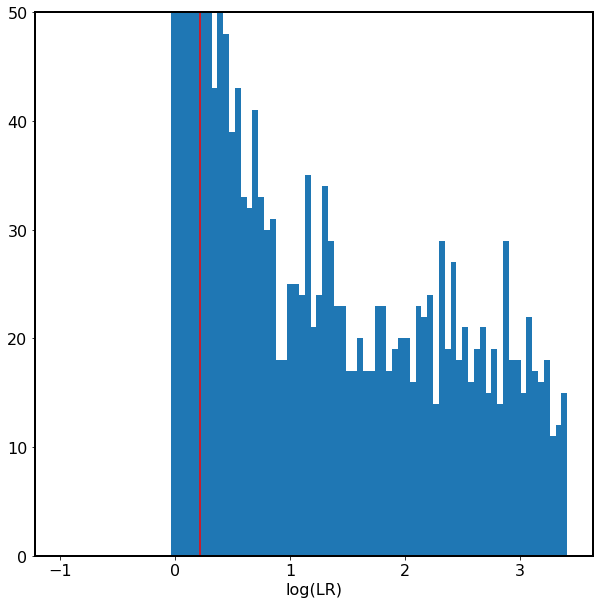

In [79]:
threshold_fin = th_runs[-1]
# threshold_fin = np.nanpercentile(final["lr_fin"], 100*(1 - Q0))
print("Q0: " + str(Q0))
print("Final Threshold: ", threshold_fin)

print("No of nan LRs: " + str(len(final[np.isnan(final["lr_fin"])])))

print("No of sources below 0.1: " + 
      str(len(final["lr_fin"][final["lr_fin"] < 0.1])))

vlow_lr_k = final["lr_fin"][final["lr_fin"] < 0.1]
varstat(vlow_lr_k)

print("No of sources below threshold: " + 
      str(len(final["lr_fin"][final["lr_fin"] <=threshold_fin])))

fig = plt.figure()
lr_be = logspace_bins(0.1, np.nanmax(final["lr_fin"]), 0.05)
plt.hist(final["lr_fin"][~np.isnan(final["lr_fin"])], bins=lr_be)
plt.axvline(threshold_fin, 0, 1, color='r')
plt.ylim([0., 50])

# plt.yscale('log')
plt.xlabel('log(LR)')
# plt.xscale('log')

Cross-over threshold from the final run: 0.14


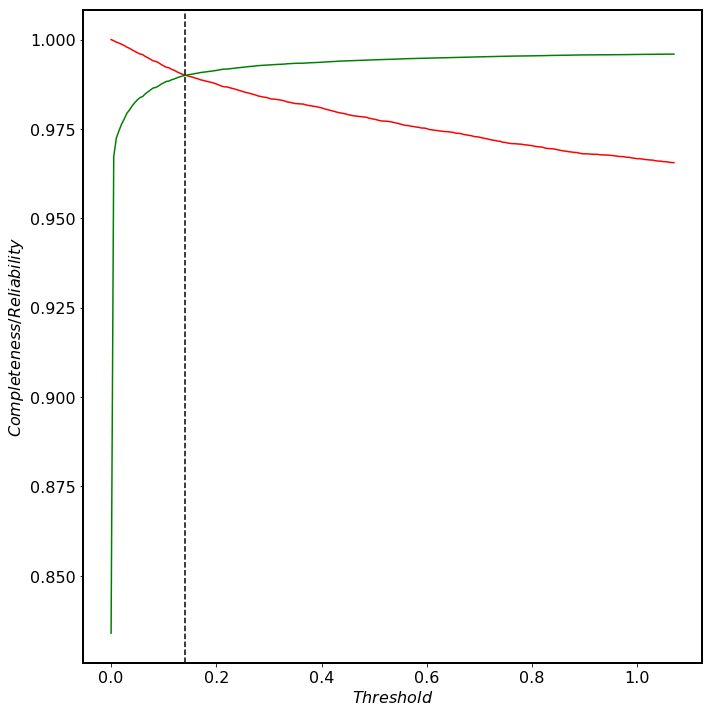

In [80]:
# Compute the completeness and reliability and plot them
thresholds = np.arange(0., 5 * threshold_fin, 0.005)
th_cross, completeness_t, reliability_t = comp_rel_threshold(final["lr_fin"], thresholds, Q0)

print("Cross-over threshold from the final run: {0}".format(th_cross))

fig = plt.figure()
plt.plot(thresholds, completeness_t, "r-")
plt.plot(thresholds, reliability_t, "g-")
# plt.plot(thresholds, average_t, "k-")
plt.axvline(th_cross, color="k", ls="--")
plt.xlabel(r"$Threshold$")
plt.ylabel(r"$Completeness/Reliability$")
# plt.xscale('log')
plt.tight_layout()
plt.savefig(outdir_name+"/completeness_reliability_fin.pdf")
# plt.close()

In [81]:
# Take the fraction of sources which have a LR above threshold compared with the no. of radio
# sources that had a match around lop_opt_radius
lr_above_th = ((~np.isnan(final["lr_fin"])) & (final["lr_fin"] >= threshold_fin))
print(np.sum(lr_above_th)/len(final))

0.827810650887574


In [82]:
# Save the results by copying the LR results to the FULL deepfull catalogue
deepfull["lr_fin"] = np.nan
deepfull["lr_dist_fin"] = np.nan
deepfull["lr_index_fin"] = np.nan

# Set all sources below the threshold to be nan? - NEED TO DO THIS WHEN RUNNING IT PROPERLY
print("NOT SETTING THE SOURCES BELOW THRESHOLD TO NaNs!")

deepfull["lr_fin"][forlr_indx] = final["lr_fin"]
deepfull["lr_dist_fin"][forlr_indx] = final["lr_dist_fin"]
deepfull["lr_index_fin"][forlr_indx] = final["lr_index_fin"]

field = "Bootes"

# Write the deepfull to file
deepfull.write(outdir_name + "/" + field + "_ML_RUN_fin_overlap" + cat_type + ".fits", format='fits', overwrite=True)
# deepfull.write(outdir_name + "/" + field + "_ML_RUN_fin_overlap" + cat_type + ".txt", format='ascii', overwrite=True)

NOT SETTING THE SOURCES BELOW THRESHOLD TO NaNs!


In [83]:
# Move the HTML notebook to the output directory
os.system("jupyter-nbconvert MaxL_RUN2_iter.ipynb && mv MaxL_RUN2_iter.html {0}".format(outdir_name))

0